# Exploring Ensemble Forecasting with the Minimal Substorm Model

### First stab at a perturbed input ensemble
### Determining predictive skill...

In [1]:
import datetime as dt
import os

import numpy as np
import matplotlib as mpl
import matplotlib.dates as mpd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.omni as om
import spacepy.plot as splot

import substorm_model as msm
splot.style('default')
mpl.rcParams.update({'font.size': 15})
%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
np.random.seed(1337)
startdate = dt.datetime(2005,1,1)
enddate = dt.datetime(2005,1,31)

#load series of substorm onsets to test against
jhdata = dm.fromHDF5('onset_lists.h5')
t_JHobs = [dt.datetime(2000,1,1)+dt.timedelta(seconds=val) for val in jhdata['obs']['All']]
t_JHobs = np.array([t for t in t_JHobs if ((t>dt.datetime(2004,12,31,22,0)) and (t<dt.datetime(2005,1,18))) ])
firstonset = t_JHobs[0]
print(firstonset)

2004-12-31 22:08:00


## Get solar wind data to drive ensemble
We'll be perturbing the solar wind driver, which in this case is calculated using a block resampling, so we first an appropriate set of data then add the errors for each ensemble member.

In [3]:
def fixOMNIVars(data):
    maglim = (-100, 100)
    vellim = (-1500, 1500)
    vlims = {'BX_GSE': maglim,
     'BY_GSE': maglim,
     'BZ_GSE': maglim,
     'BY_GSM': maglim,
     'BZ_GSM': maglim,#'Btot': (-150,150),
     'flow_speed': vellim,
     'Vx': vellim,
     'Vy': vellim,
     'Vz': vellim,
    }
    for key in vlims:
        ll = vlims[key][0]
        ul = vlims[key][1]
        data[key][data[key]>ul] = np.nan
        data[key][data[key]<ll] = np.nan
        not_nan = np.logical_not(np.isnan(data[key]))
        indices = np.arange(len(data[key]))
        data[key][...] = np.interp(indices, indices[not_nan], data[key][not_nan])
        
    return data

In [4]:
#Load IMF data and error series
homedir = os.path.expanduser('~')
data = dm.fromCDF(os.path.join(homedir, 'projects/Data/OMNI/omni_hro_1min_20041201_v01.cdf'))
data2 = dm.fromCDF(os.path.join(homedir, 'projects/Data/OMNI/omni_hro_1min_20050101_v01.cdf'))
for key in data:
    data[key] = dm.dmarray.concatenate(data[key], data2[key])
del data2

bzerr = dm.fromHDF5(os.path.join(homedir, 'projects/Data/MBB_Bz_GSM_errors.h5'))
vxerr = dm.fromHDF5(os.path.join(homedir, 'projects/Data/MBB_Vx_GSE_errors.h5'))

data = fixOMNIVars(data)


/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


In [5]:
def getErrors(errseries, nreq):
    if len(errseries)>= nreq: return errseries[:nreq]
    outerr = np.zeros(nreq)
    nloops = nreq//len(errseries)
    remain = nreq-nloops*len(errseries)
    stind, enind = 0, len(errseries)
    for il in range(nloops):
        outerr[stind:enind] = errseries
        stind += len(errseries)
        enind += len(errseries)
    outerr[stind:] = errseries[:remain]
    return outerr

In [6]:
ticks = [firstonset, enddate]
inds = tb.tOverlapHalf(ticks, data['Epoch'])

n_runs = vxerr['errors'].shape[0]
bz = np.empty([n_runs, len(inds)])
vx = np.empty([n_runs, len(inds)])
theta = np.empty([n_runs, len(inds)])
btot = np.empty([n_runs, len(inds)])
bz[0,:] = data['BZ_GSM'][inds]
vx[0,:] = -1*data['Vx'][inds]
theta[0,:] = np.arctan2(data['BY_GSM'][inds], data['BZ_GSM'][inds])
for run_num in range(1, n_runs):
    bzerrors = getErrors(bzerr['errors'][run_num, :], len(inds))
    vxerrors = getErrors(vxerr['errors'][run_num, :], len(inds))
    bz[run_num, :] = data['BZ_GSM'][inds] + bzerrors
    vx[run_num, :] = -1*data['Vx'][inds] + vxerrors
    dum = np.vstack([data['BX_GSE'][inds], data['BZ_GSM'][inds], bz[run_num, :]])
    btot[run_num, :] = np.array([tb.hypot(n) for n in dum.T])
    theta[run_num, :] = np.arctan2(data['BY_GSM'][inds], bz[run_num, :])
#put into SI
btot = btot*1e-9
vel = vx*1e3

times = data['Epoch'][inds]
epsilon = np.empty([n_runs, len(inds)])
for run_num in range(n_runs):
    epsilon[run_num, :] = (1/4e-7) * np.sin(theta[run_num, :]/2.0)**4 * vel[run_num, :] * btot[run_num, :]**2

In [7]:
#MSM setup
delta = dt.timedelta(seconds=60) #1 minute time resolution
minlen = dt.timedelta(hours=27) #set to minimum of 27 hours, to ensure that the whole interval is continuous
istart, iend = msm.findContiguousData(times, delta, minLength=minlen)

## Now we want to do an ensemble of forecasts

We want the results to be reproducible, but varying, so we set a seed for the sequence of restart values.

In [8]:
### For the perturbed parameter ensemble we have random restarts, here, we want to start on a substorm onset
#np.random.seed(7)
#seed_seq = np.random.randint(0, 1e6, n_runs)
istart, iend

([0], [43312])

In [9]:
results = []
for idx in range(n_runs):
    results.append(msm.msm(delta, times, epsilon[idx, :], istart, iend, 
                           tau0=2.69*3600, restartmode='onset'))

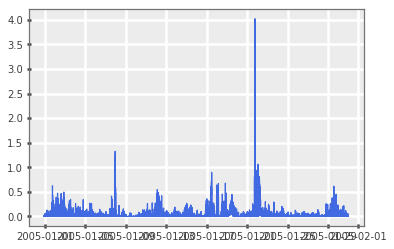

In [10]:
plt.plot(times, epsilon[1,:]*1e3)

In [11]:
t_arr = [np.array(r['t']).squeeze() for r in results]
n_valid = []
for arr in t_arr:
    n_valid.append(len(arr[arr>dt.datetime(2005,1,1)]))

print(np.mean(n_valid), np.median(n_valid), np.max(n_valid), np.min(n_valid))
print(np.argmax(n_valid))

141.95 55.0 43200 23
0


In [12]:
windowticks = spt.tickrange(startdate, enddate, dt.timedelta(minutes=30))
wh = dt.timedelta(minutes=15)
numSS = []
binnedRuns = np.zeros([len(windowticks.UTC),500])
for idx_t, tt in enumerate(windowticks.UTC):
    SSinwin = []
    ttcomp = []
    for idx_a, arr in enumerate(t_arr):
        truthtable = np.logical_and(arr>tt-wh, arr<=tt+wh)
        binnedRuns[idx_t,idx_a] = truthtable.sum()
        SSinwin.append(np.any(truthtable))
    numSS.append(np.sum(SSinwin))

In [13]:
print(np.max(numSS))
print(np.argmax(numSS))

379
995


/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


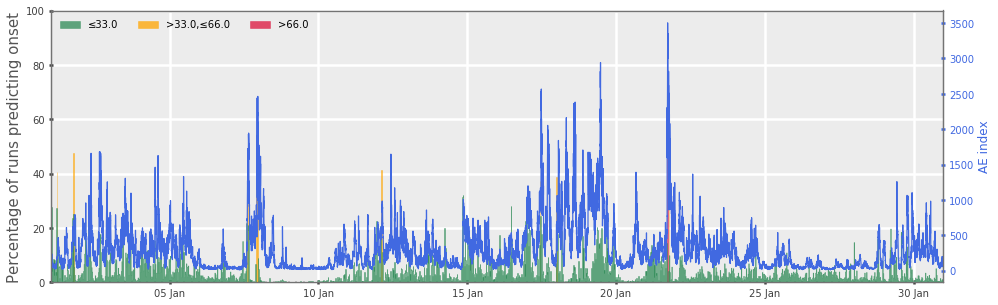

In [14]:
fig, ax = splot.set_target(None,figsize=(16,5))
ax2 = ax.twinx()
ax2.grid(False)
pltinds = tb.tOverlapHalf([windowticks.UTC[0], windowticks.UTC[-1]], data['Epoch'])
ax2.plot(data['Epoch'][pltinds], data['AE_INDEX'][pltinds], 'royalblue')
ax2.tick_params(axis='y', colors='royalblue')
ax2.set_ylabel('AE index', color='royalblue')
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(33., 66.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=True)
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.set_ylim([0,100])
plt.savefig('MSM__PIensemble_forecast_Jan2005_N=500_ALoverplot.png')

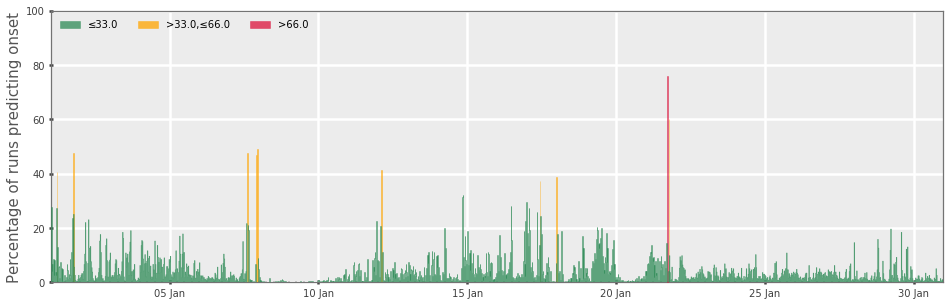

In [15]:
fig, ax = splot.set_target(None,figsize=(16,5))
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(33., 66.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=True)
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.set_ylim([0,100])
plt.savefig('MSM__PIensemble_forecast_Jan2005_N=500.png')

/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: numpy.percentile
  if __name__ == '__main__':
/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: numpy.percentile


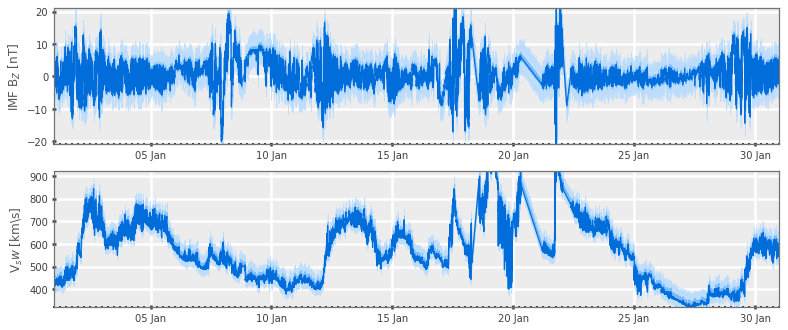

In [16]:
tlims = [windowticks.UTC[0], windowticks.UTC[-1]]
fig = plt.figure(figsize=(13,5.5))
ax = fig.add_subplot(211)
uq = np.empty(len(bz[0,:]))
lq = np.empty(len(bz[0,:]))
p025 = np.empty(len(bz[0,:]))
p975 = np.empty(len(bz[0,:]))
for n in range(len(bz[0,:])):
    p025[n], lq[n], uq[n], p975[n] = mlab.prctile(bz[:, n], (2.5, 25, 75, 97.5))
ax.fill_between(times, p025, p975, color=(0.7137,0.8588,1), alpha=0.8)
ax.fill_between(times, lq, uq, color=(0.4275,0.7137,1), alpha=0.8)
ax.plot(times, bz[0, :], color=(0,0.4275,0.8588))
splot.applySmartTimeTicks(ax, tlims)
ax.set_ylabel('IMF B$_Z$ [nT]')
ax.set_xlim(tlims)
ax.set_ylim([-21,21])
ax2 = fig.add_subplot(212)
for n in range(len(vx[0,:])):
    p025[n], lq[n], uq[n], p975[n] = mlab.prctile(vx[:, n], (2.5, 25, 75, 97.5))
ax2.fill_between(times, p025, p975, color=(0.7137,0.8588,1), alpha=0.8)
ax2.fill_between(times, lq, uq, color=(0.4275,0.7137,1), alpha=0.8)
ax2.plot(times, vx[0, :], color=(0,0.4275,0.8588))
ax2.set_ylabel('V$_sw$ [km\s]')
ax2.set_xlim(tlims)
ax2.set_ylim([320,920])
splot.applySmartTimeTicks(ax2, tlims)
plt.savefig('PIens_Jan2005_Vsw_Bz.png')

## Now let's get a sequence of observed substorms to test against...

In [17]:
#jhdata = dm.fromHDF5('onset_lists.h5')
#t_JHobs = [dt.datetime(2000,1,1)+dt.timedelta(seconds=val) for val in jhdata['obs']['All']]
#t_JHobs = np.array(t_JHobs)
#sophie = dm.readJSONheadedASCII('/mnt/projects/Notebooks/SOPHIE_EPT90_Jan05.txt', convert=True)
####SOPHIE EPT90 list
##select only expansion phase onsets (phase 2)
#expmask = sophie['Phase']==2
#validmask = sophie['Flag']==0
#sophiemask = np.bitwise_and(expmask,validmask)
#t_sophie = sophie['DateTime'][sophiemask]
###B&Y
#borov_data_raw = np.loadtxt('/mnt/projects/Notebooks/Borov_SML_Jan2005.txt')
#t_borov = np.asarray([dt.datetime(2005,1,1)+dt.timedelta(days=fd-1) for fd in borov_data_raw[:,2]])
#tBorovdiff = (t_borov[1:]-t_borov[:-1])
#tauBorov = np.asarray([t.total_seconds() for t in tBorovdiff])/3600.

In [18]:
#tJHdiff = (t_JHobs[1:]-t_JHobs[:-1])
#tauJH = np.asarray([t.total_seconds() for t in tJHdiff])/3600.
#tSOPHdiff = (t_sophie[1:]-t_sophie[:-1])
#tauSOPH = np.asarray([t.total_seconds() for t in tSOPHdiff])/3600.
if 1==0:
    plt.figure(figsize=(12,9))
    pltbins = np.hstack([np.arange(0,12,0.5), np.arange(12.5,25.1,1)])
    #try plotting MSM tau histogram for each ensemble member using a very thin grey line, see what it looks like
    sum_n = np.zeros(pltbins.shape[0]-1)
    for ind in range(500):
        tmptau = t_arr[ind][1:]-t_arr[ind][:-1]
        plttau = np.asarray([t.total_seconds() for t in tmptau])/3600.
        if ind==0:
            n, bins, patches = plt.hist(plttau, bins=pltbins, normed=True, fill=False, 
                                        histtype='step', linewidth=2.0, color='silver', label='MSM - Individual runs')
        else:
            n, bins, patches = plt.hist(plttau, bins=pltbins, normed=True, fill=False, 
                                        histtype='step', linewidth=0.5, color='silver')
        sum_n += n
    mean_n = sum_n/500.
    ##mean MSM tau histo??
    #plt.plot(tb.bin_edges_to_center(pltbins), mean_n, drawstyle='steps', color='dimgrey', label='MSM mean')

    #or normed hist for full set of MSM runs??
    all_tau = np.array([])
    print(all_tau.shape)
    for ind in range(500):
        tmp_tau = t_arr[ind][1:]-t_arr[ind][:-1]
        tmp_tau_hr = np.asarray([t.total_seconds() for t in tmptau])/3600.
        all_tau = np.hstack([all_tau, tmp_tau_hr])

#plt.hist(all_tau, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='crimson', label='MSM - All runs (Mean={:0.2f}hr)'.format(all_tau.mean()))
#
#plt.hist(tauBorov, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='B&Y (Mean={:0.2f}hr)'.format(tauBorov.mean()), color='royalblue')
#plt.xlim([0,25])
#plt.ylim([0,0.4])
#plt.xlabel(r'$\tau$ [hours]', fontsize=16)
#plt.vlines(tauBorov.mean(),0,1, linestyles='dashed', color='royalblue')
#plt.legend()
#plt.savefig('PIens_intersubstorm_intervals_BandY.png')

In [19]:
#fig = plt.figure(figsize=(12,9))
#ax = fig.add_subplot(111)
#plot taus
#n, bins, patches = ax.hist(tauSOPH, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='Observed SOPHIE (Mean={:0.2f}hr)'.format(tauSOPH.mean()), color='violet')

####Borovsky SML list
#ax.hist(tauBorov, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='royalblue', label='Borovsky SML (Mean={:0.2f}hr)'.format(all_tau.mean()))
#ax.hist(all_tau, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2,
#         color='crimson', label='MSM - All runs (Mean={:0.2f}hr)'.format(all_tau.mean()))
#ax.hist(tauJH, bins=pltbins, normed=True, fill=False, histtype='step', linewidth=2, 
#         label='Observed JH (Mean={:0.2f}hr)'.format(tauJH.mean()), color='seagreen')
#ax.legend()
#plt.savefig('PIens_compare_observed_intersubstorm.png')

In [20]:
SSyesno = []
SSsource = 'Obs' # ('Obs','SOPHIE','B&Y')
for tt in windowticks.UTC:
    if SSsource.upper()=='OBS':
        SSyesno.append(np.any(np.logical_and(t_JHobs>tt-wh, t_JHobs<=tt+wh))) # JH list
    elif SSsource.upper()=='SOPHIE':
        SSyesno.append(np.any(np.logical_and(t_sophie>tt-wh, t_sophie<=tt+wh))) #SOPHIE EPT90
    elif SSsource.upper()=='B&Y':
        SSyesno.append(np.any(np.logical_and(t_borov>tt-wh, t_borov<=tt+wh))) #Borovsky SML
    else:
        raise Exception
SSyesno = dm.dmarray(SSyesno)
print('Using {} list, which has {} substorm onsets'.format(SSsource, SSyesno.sum()))
#print(np.where(t_borov))

Using Obs list, which has 65 substorm onsets


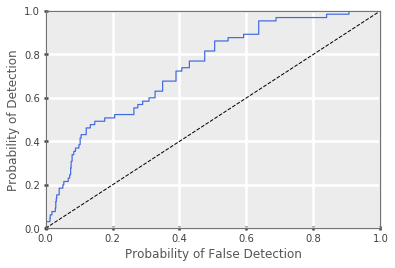

In [21]:
from sklearn.metrics import roc_curve
from verify import Contingency2x2
from verify.plot import rocCurve, reliabilityDiagram
#fpr, tpr, thresholds = roc_curve(SSyesno, np.asarray(numSS)/5.)
result = rocCurve(np.asarray(numSS)/5., SSyesno, nthresh=1000)
thresholds = result['Thresholds']
tpr = result['POD'][1:-1]
fpr = result['POFD'][1:-1]
EnsembleThresh = thresholds[np.argmax(tpr-fpr)]
FPRAtThresh = fpr[thresholds==EnsembleThresh]

Number of runs with +ve skill: 0
Number of runs with 0/-ve skill: 0


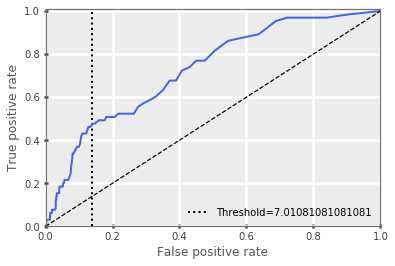

In [22]:
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.vlines(FPRAtThresh, 0, 1, linestyles=':', lw=2, label='Threshold={}'.format(EnsembleThresh))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1.01])
    
####
#plt.title('ROC curve - MSM & {}'.format(SSsource))
sourcetitle = SSsource.replace('&','and') if '&' in SSsource else SSsource

####
#add TPR/FPR for sample runs
goodcount = 0
badcount = 0
if False: #for rn in np.random.randint(0,499,100):#[1, 73, 101, 173, 201, 273, 301, 373]:
    ct = Contingency2x2.fromBoolean(binnedRuns[:,rn], SSyesno)
    #ct.summary(True)
    tpr, tpr_err = ct.POD(ci=True)
    fpr, fpr_err = ct.POFD(ci=True)
    if tpr-fpr>0.25:
        goodcount += 1
        plt.errorbar(fpr, tpr, xerr=fpr_err, yerr=tpr_err, fmt='o', color='seagreen', ecolor='g', capsize=2, capthick=2)
    if tpr-fpr<=0:
        badcount+=1
        plt.errorbar(fpr, tpr, xerr=fpr_err, yerr=tpr_err, fmt='o', color='r', ecolor='r', capsize=2, capthick=2)
print('Number of runs with +ve skill: {}'.format(goodcount))
print('Number of runs with 0/-ve skill: {}'.format(badcount))
plt.savefig('MSM_PIensemble_{}_ROC_.png'.format(sourcetitle))

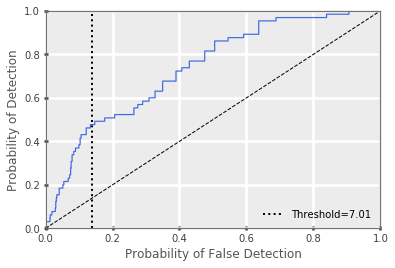

In [23]:
import verify.plot
dum = verify.plot.rocCurve(np.asarray(numSS)/5., SSyesno, nthresh=1000)
plt.vlines(FPRAtThresh, 0, 1, linestyles=':', lw=2, label='Threshold={:0.2f}'.format(EnsembleThresh))
plt.legend(loc='lower right')
plt.savefig('MSM_PIensemble_{}_ROC_.png'.format(sourcetitle))
plt.show()

/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


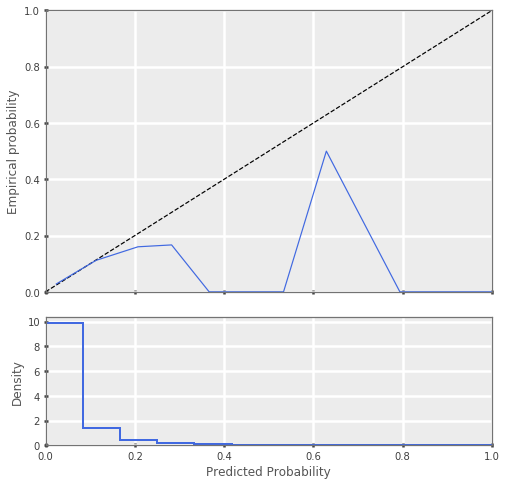

In [24]:
dum = verify.plot.reliabilityDiagram(np.asarray(numSS)/5., SSyesno, bins=12, norm=True)
plt.savefig('perturbedinput_MSM_Jan2005_reliability.png')
plt.show()

## Let's try to calibrate the model by fitting a logistic regression to the "probabilities"
Use uncalibrated, predicted probability as predictor variable, and observed outcome as binary target variable.

First we'll plot raw probability (x) versus outcome (y).

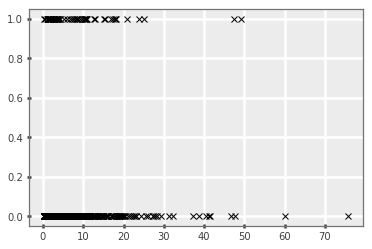

In [25]:
plt.plot(np.asarray(numSS)/5., SSyesno, 'kx')

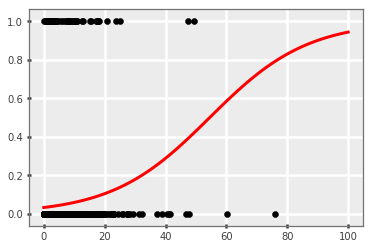

In [28]:
from sklearn import linear_model
from scipy.special import expit
clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
X = np.asarray(numSS)/5.
X = X[:, np.newaxis]
clf.fit(X, SSyesno)
plt.scatter(X.ravel(), SSyesno, color='black', zorder=20)
X_test = np.linspace(0, 100, 100)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

Well... that's not going to work here. Too many misses,
and the high values aren't necessarily more likely to occur at an onset

Need to:
1. use a longer run to get calibration data
2. Consider "resetting" or "updating" as the prediction progresses... look through the recent history to find a likely onset, restart ensemble (to minimize initial condition errors)



Text(0, 0.5, 'Binary Event Prob.')

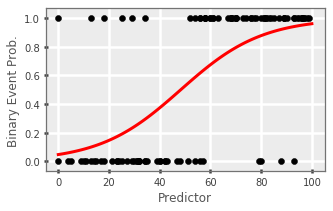

In [36]:
#Make a figure to illustrate LR
testBinary = np.zeros(100)
testBinary[45:] = 1
swapinds = np.random.randint(100, size=15)
testBinary[swapinds] = 1 - testBinary[swapinds]

clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
X = np.random.randint(100, size=100)
X.sort()
X = X[:, np.newaxis]
clf.fit(X, testBinary)
plt.figure(figsize=(5,3))
plt.scatter(X.ravel(), testBinary, color='black', zorder=20)
X_test = np.linspace(0, 100, 100)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)
plt.xlabel('Predictor')
plt.ylabel('Binary Event Prob.')

/net/toaster/u/smorley/miniconda3/envs/default/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


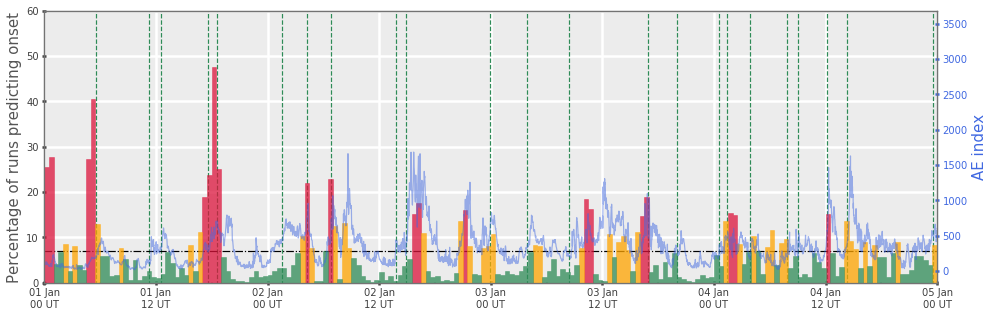

In [26]:
fig, ax = splot.set_target(None,figsize=(16,5))
splot.levelPlot(np.asarray(numSS)/5., time=windowticks.UTC, levels=(EnsembleThresh-0.01, EnsembleThresh*2.), target=ax, 
                colors=['seagreen', 'orange', 'crimson'], legend=False)
for ots in t_JHobs:
    plt.vlines(ots, -5000,2000, linestyles='dashed', color='seagreen')
ax.set_ylim([0,60])
ax.set_ylabel('Percentage of runs predicting onset', fontsize=15)
ax.hlines(EnsembleThresh, windowticks.UTC[0], windowticks.UTC[-1], linestyles='-.')
ax2 = ax.twinx()
ax2.grid(False)
pltinds = tb.tOverlapHalf([windowticks.UTC[0], windowticks.UTC[-1]], data['Epoch'])
ax2.plot(data['Epoch'][pltinds], data['AE_INDEX'][pltinds], 'royalblue', alpha=0.5)
ax2.tick_params(axis='y', colors='royalblue')
ax2.set_ylabel('AE index', color='royalblue', fontsize=15)
ax.set_xlim([dt.datetime(2005,1,1), dt.datetime(2005,1,5)])
ax2.xaxis.set_major_formatter(mpd.DateFormatter('%d %b\n%H UT'))
plt.savefig('MSM_PIensemble_forecast_Jan2005_N=500_thresh.png')
##TODO: Add observed onsets to plot. Make sure list has manually identified onsets from Morley paper

### Now we choose the threshold that gave us the largest positive deviation and generate a contingency table for analysis

In [27]:
fracPredict = 100*np.asarray(numSS)/float(n_runs)
PredAtThresh = fracPredict>=EnsembleThresh

ctable = Contingency2x2.fromBoolean(PredAtThresh, SSyesno)
print(ctable)
print('\n')
ctable.summary(verbose=True, ci='bootstrap')

[[  31  192]
 [  34 1184]]


Contingency2x2([
  [    31,   192],
  [    34,  1184])

Summary Statistics
Bias: 3.4308 [2.7221, 4.4817]
FAR: 0.8610 [0.8148, 0.9022]
PC: 0.8432 [0.8244, 0.8626]
POFD: 0.1395 [0.1217, 0.1589]
POD: 0.4769 [0.3571, 0.6000]
ThreatScore: 0.1206 [0.0843, 0.1623]
OddsRatio: 5.6225

Skill Scores
HeidkeScore: 0.1563 [0.0987, 0.2200]
PeirceScore: 0.3374 [0.2192, 0.4640]
EquitableThreatScore: 0.0848 [0.0519, 0.1236]
YuleQ: 0.6980

Classification Quality Metrics
MajorityClassFraction: 0.9549
MatthewsCC: 0.1936


## Notable results
- The MSM is overpredicting substorms relative to this list of observed onsets
- The low threshold increases the bias
- The "best" prediction (ratio of True Pos to False Pos) gives a high rate of false positives
- The predictive skill is higher than th SWMF runs...
- Proportion correct is lower than the majority class fraction (PC for case where all predictions are majority type)

## Let's just plot some of the substorm activity for the month out...

In [ ]:
#tlims = [dt.datetime(2005,1,28,19), dt.datetime(2005,1,31)]
#pltinds = tb.tOverlapHalf(tlims, times)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(data['Epoch'][pltinds], data['AL_INDEX'][pltinds], 'royalblue')
ax.plot(data['Epoch'][pltinds], data['AU_INDEX'][pltinds], 'royalblue')
ax.set_xlim(tlims)
ax.set_ylabel('AU/AL [nT]')
plt.savefig('Jan2005zoom_AU_AL_activity.png')

In [ ]:
###Find MSM run with highest skill
score = []
tables = []
for pred_ind in binnedRuns.T:
    ctable_ind = Contingency2x2.fromBoolean(pred_ind, SSyesno)
    tables.append(ctable_ind)
    score.append(ctable_ind.peirce())
score = np.asarray(score)
best_indi = np.argmax(score)
print('{} runs have same max score'.format((score==score.max()).sum()))
print(np.where(score==score.max()))
print('Using run # {}'.format(best_indi))
tables[np.argmax(score)].summary(verbose=True, ci='bootstrap')

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.plot(data['Epoch'][pltinds], data['AL_INDEX'][pltinds], 'royalblue')
ax.plot(data['Epoch'][pltinds], data['AU_INDEX'][pltinds], 'royalblue')
ax.set_xlim(tlims)
##add onsets from a random MSM run
for ots in t_arr[best_indi]:
    plt.vlines(ots, -5000,2000, linestyles='dotted', color='k')
#and add observed onsets 
for ots in t_JHobs:
    plt.vlines(ots, -5000,2000, linestyles='dashed', color='seagreen')
ax.set_ylim([-2000, 900])
ax.set_xlim([dt.datetime(2005,1,1), dt.datetime(2005,1,3)])
ax.set_ylabel('AU/AL [nT]')
ax.set_title('Individual MSM (black) ; Observations (green)')
ax.xaxis.set_major_formatter(mpd.DateFormatter('%d %b\n%H UT'))
plt.savefig('MSM_PI_bestrun_vs_ObsJH.png')